In [56]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import roc_auc_score
import timm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [58]:
model = timm.create_model('inception_resnet_v2', pretrained=True)
num_features = model.classif.in_features
num_classes = 2
model.classif = nn.Linear(num_features, num_classes)
model = model.to(device)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True) # ReducePROnPlateau: Vliation Loss가 개선되지 않을 때, 학습률을 동적으로 조정

In [60]:
class PatientDataLoader:
    def __init__(self, root_dir, test_size=0.2, random_seed=42):
        self.root_dir = os.path.abspath(root_dir)
        self.test_size = test_size
        self.random_seed = random_seed
        self.data = self._load_data()
        self.train_data, self.valid_data = self._split_data()

    def _load_data(self):
        data = defaultdict(lambda: {"class": None, "images": []})
        class_mapping = {"ca_roi": 0, "acute_roi": 1}

        for class_folder in ['ca_roi', 'acute_roi']:
            folder_path = os.path.join(self.root_dir, class_folder)
            if not os.path.exists(folder_path):
                raise ValueError(f"폴더가 존재하지 않습니다: {folder_path}")

            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith('.jpg'):
                    patient_id = file_name.split('_')[0]
                    data[patient_id]["class"] = class_mapping[class_folder]
                    data[patient_id]["images"].append(os.path.join(folder_path, file_name))

        return data

    def _split_data(self):
        patient_ids = list(self.data.keys())
        train_ids, valid_ids = train_test_split(patient_ids, test_size=self.test_size, random_state=self.random_seed)
        train_data = {pid: self.data[pid] for pid in train_ids}
        valid_data = {pid: self.data[pid] for pid in valid_ids}
        return train_data, valid_data

In [61]:
class PatientDatasetTrain(Dataset):
    def __init__(self, data, transform=None):
        self.data = []
        self.labels = []
        for patient_id, patient_info in data.items():
            label = patient_info["class"]
            for image_path in patient_info["images"]:
                self.data.append(image_path)
                self.labels.append(label)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [62]:
class PatientDatasetValid(Dataset):
    def __init__(self, data, transform=None):
        self.data = list(data.items())
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        patient_id, patient_info = self.data[idx]
        label = patient_info["class"]
        image_paths = patient_info["images"]

        images = []
        for image_path in image_paths:
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)

        images = torch.stack(images)
        return images, label, patient_id

In [63]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [64]:
root_dir = './data_roi'
data_loader = PatientDataLoader(root_dir)
train_data, valid_data = data_loader.train_data, data_loader.valid_data

train_dataset = PatientDatasetTrain(train_data, transform=transform)
valid_dataset = PatientDatasetValid(valid_data, transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def validate(model, dataloader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images[0].to(device)  # 환자의 모든 슬라이스
            labels = labels.item()

            outputs = model(images)
            loss = criterion(outputs, torch.full((images.shape[0],), labels, dtype=torch.long, device=device))
            val_loss += loss.item()

            probs = F.softmax(outputs, dim=1)  # 각 슬라이스별 확률

            # 🔹 Weighted Soft Voting 적용
            weights = torch.max(probs, dim=1)[0]  # 각 슬라이스에서 가장 높은 확률을 가중치로 사용
            weighted_probs = torch.sum(probs * weights.view(-1, 1), dim=0) / torch.sum(weights)
            final_prediction = torch.argmax(weighted_probs).item()

            if final_prediction == labels:
                val_correct += 1
            val_total += 1

            all_labels.append(labels)
            all_preds.append(final_prediction)
            all_probs.append(weighted_probs.cpu().numpy())  

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f"Confusion Matrix:\n{conf_matrix}")

    plot_confusion_matrix(conf_matrix)

    if num_classes == 2:
        auc_score = roc_auc_score(all_labels, all_probs[:, 1])  
    else:
        auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')  

    return val_loss / len(dataloader), val_correct / val_total, auc_score, conf_matrix


In [66]:
def train(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7):
    best_val_loss = float("inf")
    early_stopping_counter = 0

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies, val_aucs = [], [], []

    confusion_matrices = []
    
    for epoch in range(num_epochs):
        print(f"\n Epoch {epoch+1}/{num_epochs}")

        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total  
        train_loss /= len(train_loader)  

        val_loss, val_acc, val_auc, conf_matrix = validate(model, valid_loader, criterion)  # AUC 추가

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_aucs.append(val_auc)  

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | Validation AUC: {val_auc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "./weights/0218_best_model_ca_acute.pth")
            print("✅ Best Model Updated & Saved!")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1  
            print(f" Early Stopping Counter: {early_stopping_counter}/{patience}")

        if early_stopping_counter == patience:
            print("⏹ Early Stopping Triggered! Training Stopped.")
            break

    plot_results(train_losses, train_accuracies, val_losses, val_accuracies, val_aucs)  

In [67]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["ca", "acute"], 
                yticklabels=["ca", "acute"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [68]:
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies, val_aucs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(18, 5))

    # 🔹 Loss 그래프
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train & Validation Loss')
    plt.legend()
    plt.grid()

    # 🔹 Accuracy 그래프
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train & Validation Accuracy')
    plt.legend()
    plt.grid()

    # 🔹 AUC 그래프 (이진 분류는 평균 AUC만 표시)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_aucs, label='Validation AUC', marker='o', color='black', linestyle='--', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation AUC')
    plt.legend()
    plt.grid()

    plt.show()



 Epoch 1/50


Confusion Matrix:
[[ 8 12]
 [ 4 19]]


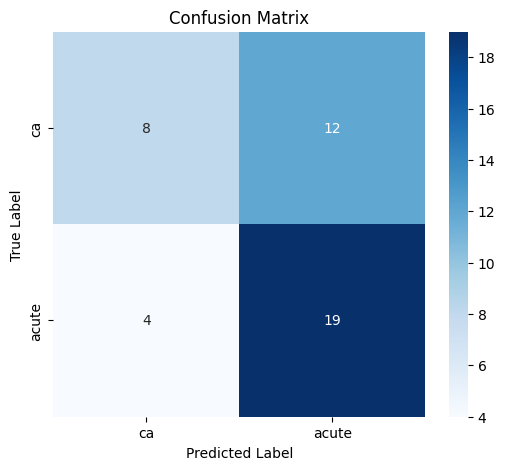

Train Loss: 0.6740 | Train Acc: 0.6048
Validation Loss: 0.6704 | Validation Acc: 0.6279 | Validation AUC: 0.7109
✅ Best Model Updated & Saved!

 Epoch 2/50


Confusion Matrix:
[[10 10]
 [ 4 19]]


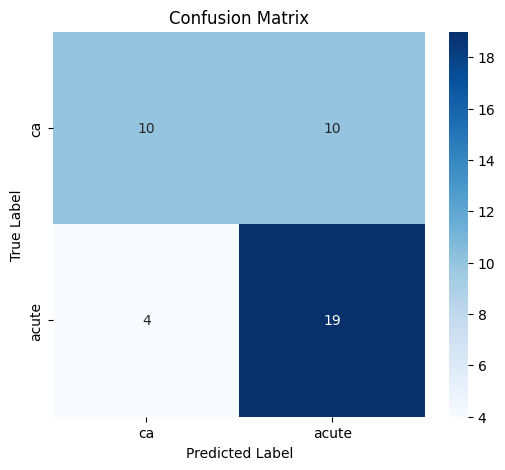

Train Loss: 0.6193 | Train Acc: 0.6774
Validation Loss: 0.6372 | Validation Acc: 0.6744 | Validation AUC: 0.7696
✅ Best Model Updated & Saved!

 Epoch 3/50


Confusion Matrix:
[[15  5]
 [ 7 16]]


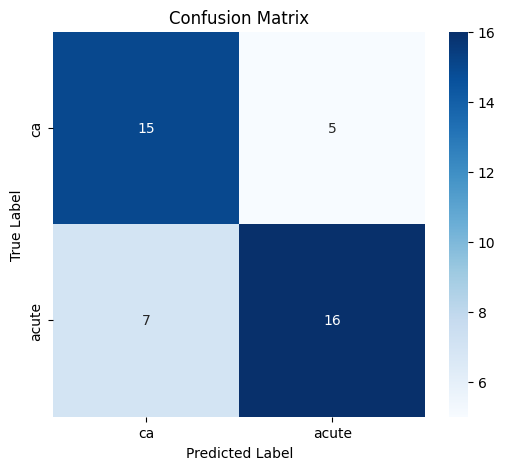

Train Loss: 0.5612 | Train Acc: 0.7145
Validation Loss: 0.6117 | Validation Acc: 0.7209 | Validation AUC: 0.8065
✅ Best Model Updated & Saved!

 Epoch 4/50


Confusion Matrix:
[[15  5]
 [ 7 16]]


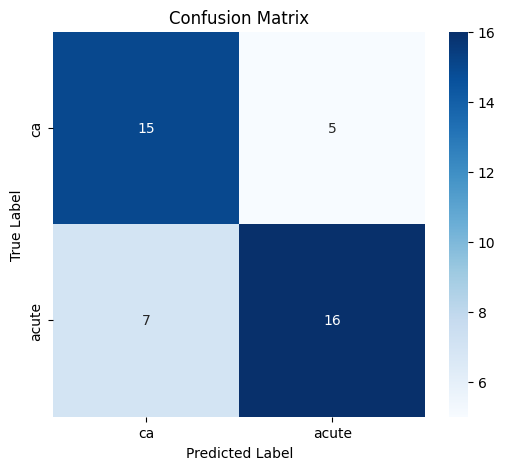

Train Loss: 0.5088 | Train Acc: 0.7629
Validation Loss: 0.6075 | Validation Acc: 0.7209 | Validation AUC: 0.8087
✅ Best Model Updated & Saved!

 Epoch 5/50


Confusion Matrix:
[[15  5]
 [ 7 16]]


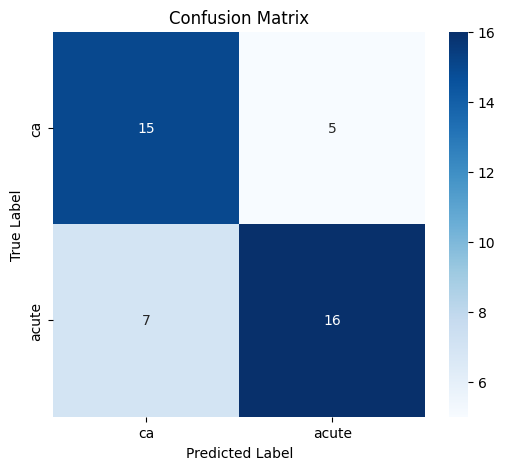

Train Loss: 0.4606 | Train Acc: 0.7809
Validation Loss: 0.6105 | Validation Acc: 0.7209 | Validation AUC: 0.8043
 Early Stopping Counter: 1/5

 Epoch 6/50


Confusion Matrix:
[[17  3]
 [ 9 14]]


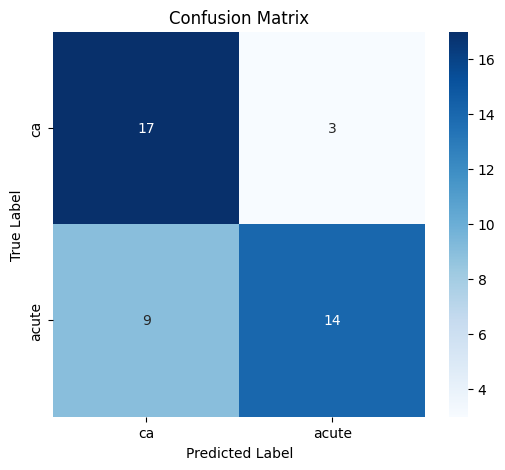

Train Loss: 0.4419 | Train Acc: 0.7938
Validation Loss: 0.6133 | Validation Acc: 0.7209 | Validation AUC: 0.8326
 Early Stopping Counter: 2/5

 Epoch 7/50


Confusion Matrix:
[[17  3]
 [ 7 16]]


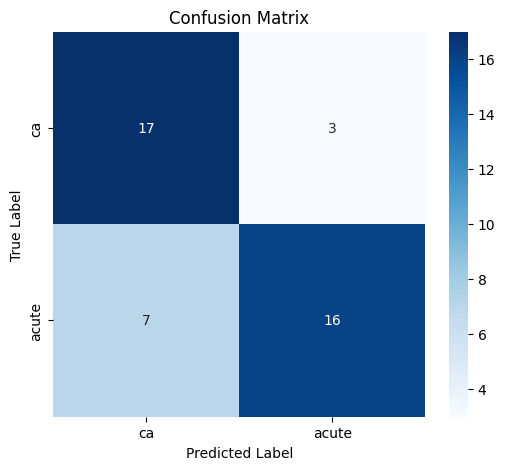

Train Loss: 0.4133 | Train Acc: 0.8147
Validation Loss: 0.6029 | Validation Acc: 0.7674 | Validation AUC: 0.8435
✅ Best Model Updated & Saved!

 Epoch 8/50


Confusion Matrix:
[[17  3]
 [ 6 17]]


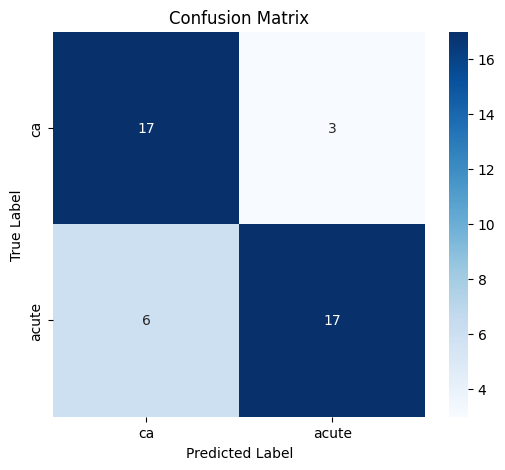

Train Loss: 0.3766 | Train Acc: 0.8280
Validation Loss: 0.6299 | Validation Acc: 0.7907 | Validation AUC: 0.8391
 Early Stopping Counter: 1/5

 Epoch 9/50


Confusion Matrix:
[[17  3]
 [ 7 16]]


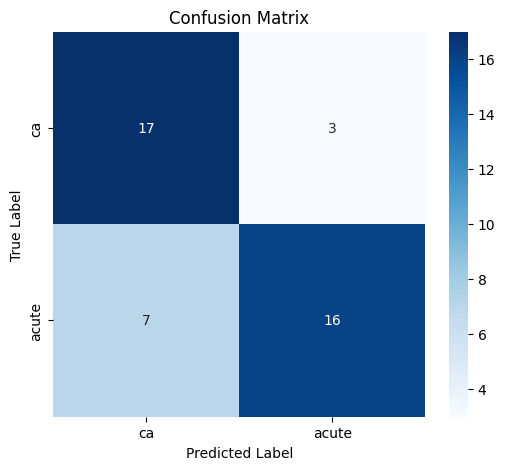

Train Loss: 0.3564 | Train Acc: 0.8431
Validation Loss: 0.6609 | Validation Acc: 0.7674 | Validation AUC: 0.8174
 Early Stopping Counter: 2/5

 Epoch 10/50


Confusion Matrix:
[[16  4]
 [ 7 16]]


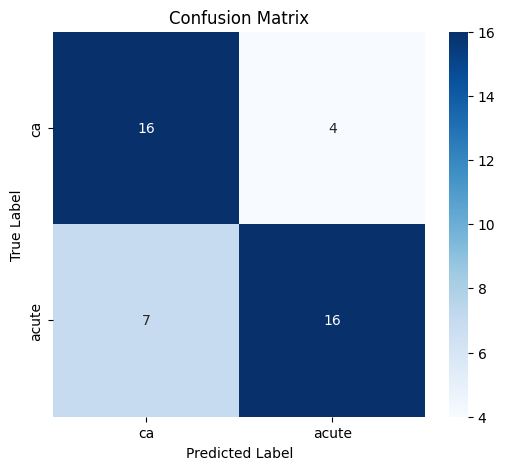

Train Loss: 0.3306 | Train Acc: 0.8531
Validation Loss: 0.6837 | Validation Acc: 0.7442 | Validation AUC: 0.8239
 Early Stopping Counter: 3/5

 Epoch 11/50


Confusion Matrix:
[[16  4]
 [ 5 18]]


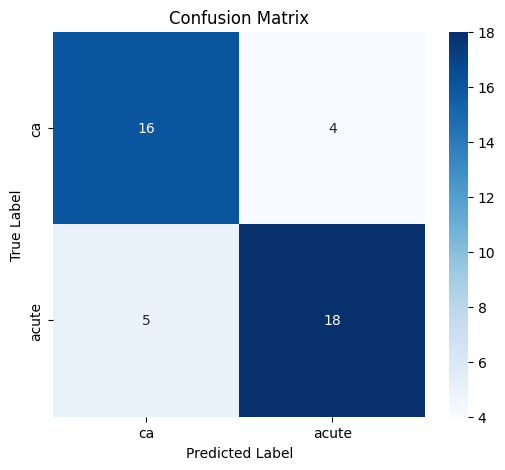

Train Loss: 0.3037 | Train Acc: 0.8631
Validation Loss: 0.6887 | Validation Acc: 0.7907 | Validation AUC: 0.8304
 Early Stopping Counter: 4/5

 Epoch 12/50


Confusion Matrix:
[[16  4]
 [ 4 19]]


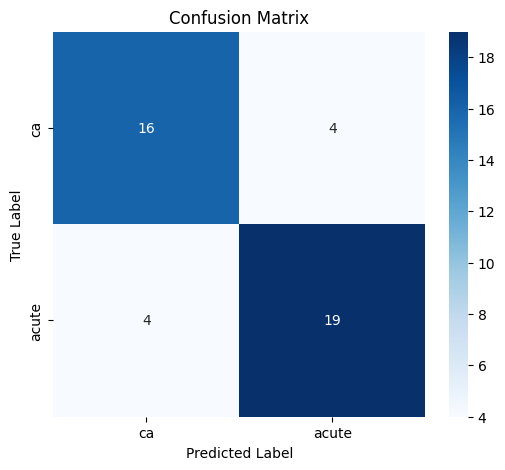

Train Loss: 0.2995 | Train Acc: 0.8715
Validation Loss: 0.6848 | Validation Acc: 0.8140 | Validation AUC: 0.8304
 Early Stopping Counter: 5/5
⏹ Early Stopping Triggered! Training Stopped.


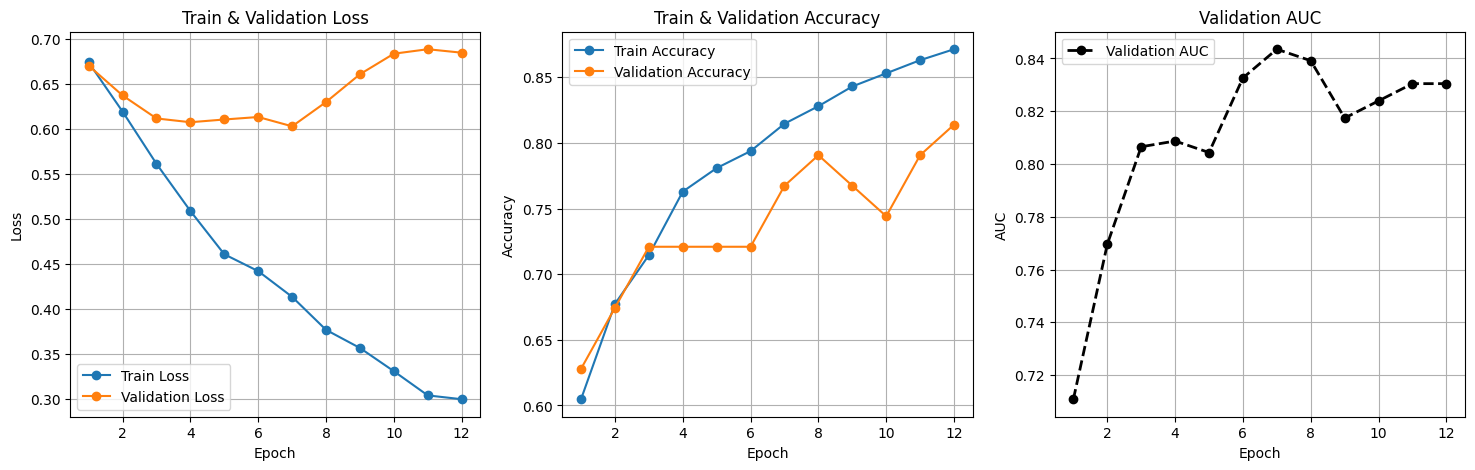

In [69]:
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)